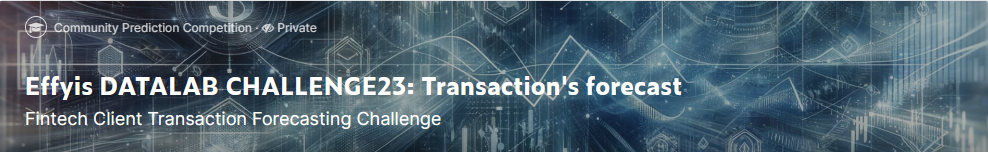

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/train-test-data/train_test_data.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Re-importing necessary libraries and loading the dataset
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load the dataset (assuming the file is correctly uploaded and named)
file_path = 'data/input/train_test_data.csv'
data = pd.read_csv(file_path)

In [4]:
data

,Date,Id_compte,amount_transaction,category_transaction
0,2022-01-01 00:23:00,SEWC_CL.1,462.96,Food & Drink - Groceries
1,2022-01-01 00:26:00,SEW0C_LI.1,15.51,General Services - Home Repair + Maintenance
2,2022-01-01 01:01:00,US.1,2.24,Bank Transfers - ATM withdrawals
3,2022-01-01 01:21:00,TA.1,2.86,Transportation - Public Transport
4,2022-01-01 01:54:00,US.1,1.68,Bank Transfers - ATM withdrawals
...,...,...,...,...
20406,2022-11-07 05:42:00,SEWC_P.1,264.60,Medical - Pharmacies and supplements
20407,2022-11-07 05:56:00,SEWC_CL.1,4.63,Bank Transfers - ATM fees
20408,2022-11-07 06:36:00,SEWC_PA.1,6.96,Transportation - Parking
20409,2022-11-07 06:37:00,SEW0C_HI.1,448.44,Subscription - Others


In [5]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')

In [6]:
# Encoding 'Id_compte' as it is a categorical feature
le = LabelEncoder()
data['Id_compte_encoded'] = le.fit_transform(data['Id_compte'])
# data['category_transaction_encoded'] = le.fit_transform(data['category_transaction'])

In [7]:
# data['Year'] = data['Date'].dt.year
# data['Month'] = data['Date'].dt.month
# data['Day'] = data['Date'].dt.day

# X = data[['Id_compte_encoded', 'Year']]
# y = data['amount_transaction']

# from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Filtering out data based on date for forecasting (e.g., keeping data after a certain date)
split_date = data['Date'].quantile(0.99999999999999)  # Using the 80th percentile date for splitting
train_data = data[data['Date'] <= split_date]
test_data = data[data['Date'] > split_date]

# Data Preprocessing
# Dropping columns not used in the model
train_data = train_data.drop(columns=['category_transaction'])
test_data = test_data.drop(columns=['category_transaction'])

# Extracting year, month, and day as features
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day

test_data['Year'] = test_data['Date'].dt.year
test_data['Month'] = test_data['Date'].dt.month
test_data['Day'] = test_data['Date'].dt.day

# Preparing the data for the model
# X_train = train_data[['Id_compte_encoded', 'Year', 'Month', 'category_transaction_encoded', 'Day']]
X_train = train_data[['Id_compte_encoded', 'Year', 'Month']]
y_train = train_data['amount_transaction']

# X_test = test_data[['Id_compte_encoded', 'Year', 'Month', 'Day']]
X_test = test_data[['Id_compte_encoded', 'Year', 'Month']]
y_test = test_data['amount_transaction']

In [9]:
X_train

,Id_compte_encoded,Year,Month
0,6,2022,1
1,5,2022,1
2,11,2022,1
3,10,2022,1
4,11,2022,1
...,...,...,...
20405,7,2022,11
20406,7,2022,11
20407,6,2022,11
20408,8,2022,11


In [10]:
y_train

0        462.96
1         15.51
2          2.24
3          2.86
4          1.68
          ...  
20405    378.00
20406    264.60
20407      4.63
20408      6.96
20409    448.44
Name: amount_transaction, Length: 20410, dtype: float64

In [15]:
# Model Development
# Using Linear Regression
# model = LinearRegression()
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
from xgboost import XGBRegressor #pip install xgboost
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
mse

407.7000989213696

In [17]:
# Generating Predictions for the Evaluation Period
# Creating a dataframe for prediction dates
prediction_dates = pd.date_range(start='2022-11-08', end='2022-12-31')
prediction_data = pd.DataFrame({
    'Date': np.repeat(prediction_dates, len(le.classes_)),
    'Id_compte_encoded': np.tile(le.transform(le.classes_), len(prediction_dates))
})

# Extracting month and day for prediction
prediction_data['Year'] = prediction_data['Date'].dt.year
prediction_data['Month'] = prediction_data['Date'].dt.month
prediction_data['Day'] = prediction_data['Date'].dt.day

# Making predictions
# X_prediction = prediction_data[['Id_compte_encoded', 'Year', 'Month', 'Day']]
X_prediction = prediction_data[['Id_compte_encoded', 'Year', 'Month']]
predicted_amounts = model.predict(X_prediction)

# Adding the predicted amounts to the prediction data
prediction_data['Predicted_Amount'] = predicted_amounts

# Creating an ID column for output
prediction_data['ID'] = prediction_data['Date'].dt.strftime('%Y-%m-%d') + '_' + le.inverse_transform(prediction_data['Id_compte_encoded'])

# Preparing the final output
final_output = prediction_data[['ID', 'Predicted_Amount']]

# Save the final output data to a CSV file
final_output.to_csv('data/output/final_output_predictions.csv', index=False)